In [2]:
import os
#os.environ["JAX_PLATFORM_NAME"] = "cpu"

import jax_sbgeom as jsb
%load_ext autoreload
%autoreload 2
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
import numpy as onp
import sys 
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)


from functools import partial
import jax_sbgeom.coils as jsc
import jax_sbgeom.flux_surfaces as jsf

from dataclasses import dataclass
import functools
from jax_sbgeom.jax_utils.utils import _mesh_to_pyvista_mesh

import matplotlib.pyplot as plt
vmec_files = ["/home/tbogaarts/stellarator_paper/base_data/vmecs/helias3_vmec.nc4", "/home/tbogaarts/stellarator_paper/base_data/vmecs/helias5_vmec.nc4", "/home/tbogaarts/stellarator_paper/base_data/vmecs/squid_vmec.nc4"]
vmec_file = vmec_files[2]

coil_files = ["/home/tbogaarts/stellarator_paper/base_data/vmecs/HELIAS3_coils_all.h5", "/home/tbogaarts/stellarator_paper/base_data/vmecs/HELIAS5_coils_all.h5", "/home/tbogaarts/stellarator_paper/base_data/vmecs/squid_coilset.h5"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
fs_base = jsb.flux_surfaces.FluxSurface.from_hdf5(vmec_file)

In [10]:
jsb.flux_surfaces.flux_surfaces_base._volume_from_fourier(fs_base.data, fs_base.settings, 1.0)

Array(1256.19973155, dtype=float64)

In [ ]:
jsb.flux_surfaces.mesh_surface(fs_base, 1.0, jsb.flux_surfaces.ToroidalExtent.full(), 300, 300)

In [ ]:

coilsd = onp.loadtxt("filament_s4uu_5ci_23")[:,:]
amax = 101
i = 0
coils = []
currents = []
for i in range(40):
#    if i not in [0, 4, 8, 12, 16, 20,24, 28, 32,35, 36,39] :
    coils.append(coilsd[i * amax : i * amax + amax -1,:-1])
    currents.append(coilsd[i * amax, -1])



jax_coils = [jsc.DiscreteCoil.from_positions(jnp.array(coil)) for coil in coils]

jax_currents = jnp.array(currents)

ERROR:2025-10-27 10:01:23,872:jax._src.xla_bridge:487: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/tbogaarts/miniconda3/envs/stellsim/lib/python3.12/site-packages/jax/_src/xla_bridge.py", line 485, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/tbogaarts/miniconda3/envs/stellsim/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 334, in initialize
    c_api = xb.register_plugin(
            ^^^^^^^^^^^^^^^^^^^
  File "/home/tbogaarts/miniconda3/envs/stellsim/lib/python3.12/site-packages/jax/_src/xla_bridge.py", line 621, in register_plugin
    c_api = xla_client.load_pjrt_plugin_dynamically(plugin_name, library_path)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tbogaarts/miniconda3/envs/stellsim/lib/python3.12/site-packages/jaxlib/xla_client.py", line 113, in load_pjrt_plugin_dynamically
    return _xl

XlaRuntimeError: FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.

In [ ]:
jax_coilset = jsc.CoilSet.from_list(jax_coils)

In [ ]:

coilset_fourier_sbg = sbg.Coils.Convert_to_Fourier_Coils(sbg.Coil_Set([sbg.Discrete_Coil(onp.array(jax_coils[0].positions))]))

In [ ]:
set_0 = coilset_fourier_sbg[0].Get_Fourier_Cos()

In [ ]:
coilset = jsc.fourier_coil.convert_to_fourier_coilset(jax_coilset)

In [ ]:
finitesize_coils = jsc.FiniteSizeCoilSet.from_coilset(coilset, jsc.RotationMinimizedFrame, 300)

In [ ]:
def interp1d_jax(x, y, x_new):    
    i = jnp.clip(jnp.searchsorted(x, x_new, side='left') - 1, 0, x.size - 2)    
    x0, x1 = x[i], x[i + 1]
    y0, y1 = y[i], y[i + 1]    
    t = (x_new - x0) / (x1 - x0)
    return y0 + t * (y1 - y0)

def arc_length_fourier(fourier_coil, s):
    tangent = jsc.fourier_coil._grad_fourier_position(fourier_coil, s)
    return jnp.linalg.norm(tangent,axis=-1)


def arc_length_fd(fourier_coil, s):
    ds = 1e-6
    pos_plus = jsc.fourier_coil._fourier_position(fourier_coil, s + ds)
    pos_minus = jsc.fourier_coil._fourier_position(fourier_coil, s - ds)
    tangent = (pos_plus - pos_minus) / (2 * ds)
    return jnp.linalg.norm(tangent, axis=-1)

arclength = arc_length_fourier(coilset[0], jnp.linspace(0,1,1000, endpoint=False))

In [ ]:
def arc_length_fd_discrete(discrete_coil, s):
    positions = discrete_coil.position( s)
    rolled_positions = jnp.roll(positions, -1, axis=0)
    diffs = rolled_positions - positions
    segment_lengths = jnp.linalg.norm(diffs, axis=-1) / (1 / len(s))
    return segment_lengths

arclength_fd_discrete_vals = arc_length_fd_discrete(jax_coilset[0], jnp.linspace(0,1,1000, endpoint=False))

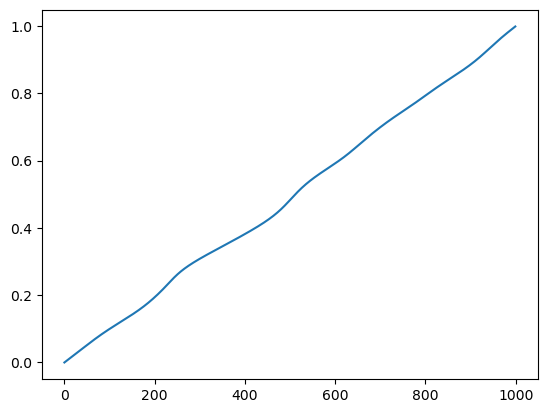

In [ ]:
from scipy.integrate import cumulative_trapezoid

def _cumulative_trapezoid_uniform_periodic(y, dx, initial=0.0):
    """Cumulative trapezoidal integration of y with respect to x, assuming uniform spacing and periodicity.
    Args:
        y: array of values to integrate.
        dx: spacing between x values.
        initial: initial value for the integral.
    Returns:
        Array of cumulative integral values.
    """    
    integrand = (y + jnp.roll(y, -1)) / 2
    integral = jnp.cumsum(integrand * dx)
    return jnp.concatenate([jnp.array([initial]), integral])


def equal_arc_length_resample(fourier_coil, n_s):
    s = jnp.linspace(0, 1.0, n_s, endpoint=False)
    arc_lengths = arc_length_fourier(fourier_coil,s)

    ds = s[1] - s[0]

    
    cumulative_arclength = _cumulative_trapezoid_uniform_periodic(arc_lengths, ds, initial=0.0)
    s_arclength_total    = jnp.linspace(0, 1.0, n_s + 1)

    normalized_cumulative_arclength = cumulative_arclength / cumulative_arclength[-1]


    resampled_s = interp1d_jax(normalized_cumulative_arclength, s_arclength_total, s)
        
    return resampled_s
    

snew = equal_arc_length_resample(coilset[0], 1000)
plt.plot(snew)
#plt.plot(snew, jnp.linspace(0,1,1000, endpoint=False))

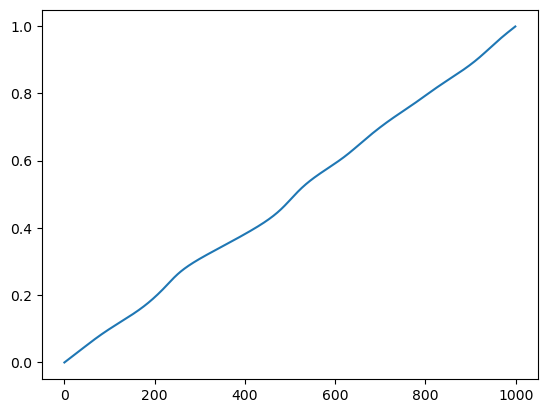

In [ ]:
sresampled = sbg.Coils.Transform_Equal_Arclength(coilset_fourier_sbg[0], 1000)
plt.plot(sresampled)

In [ ]:
positions_resampled = coilset[0].position(sresampled)

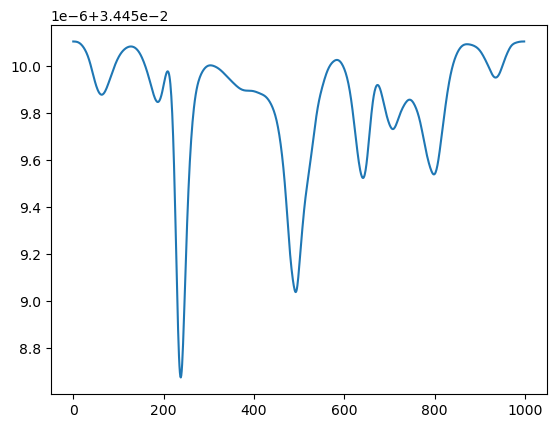

In [ ]:
plt.plot(jnp.linalg.norm(jnp.diff(positions_resampled, axis=0), axis=-1))

In [ ]:
jsc.fourier_coil.convert_to_fourier_coil()

TypeError: convert_to_fourier_coil() missing 1 required positional argument: 'coil'

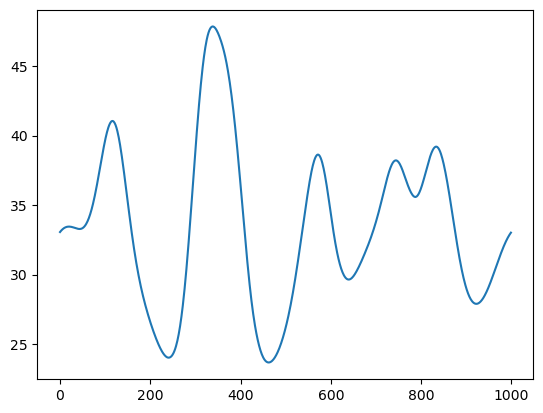

In [ ]:
plt.plot(arc_length_fourier(coilset[0],snew), label="fourier")

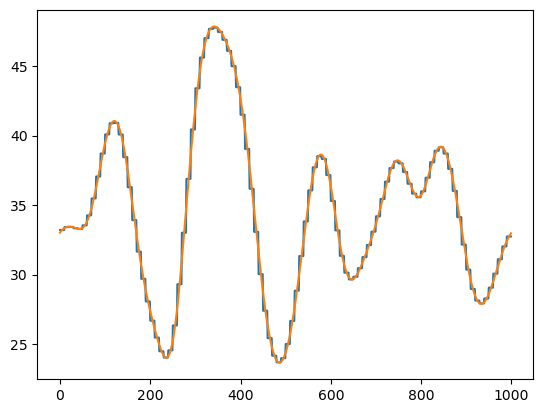

In [ ]:
plt.plot(arclength_fd_discrete_vals)
plt.plot(arclength)

In [ ]:
jsc.mesh_coilset_surface(finitesize_coils, 300, 0.3, 0.3)

(Array([[23.92124275,  1.60647668, -0.05248593],
        [23.90442923,  1.06768277, -0.3159597 ],
        [24.49737725,  1.09237532, -0.40429387],
        ...,
        [14.04264612, 20.53056378,  0.2958382 ],
        [14.18511539, 21.11328321,  0.28398157],
        [14.60649677, 21.0018696 , -0.128359  ]], dtype=float64),
 Array([[    0,     1,     4],
        [    1,     5,     4],
        [    1,     2,     5],
        ...,
        [47999, 46803, 46802],
        [47999, 47996, 46803],
        [47996, 46800, 46803]], dtype=int64))

In [ ]:
onp.testing.assert_allclose(fourier_coilset[0].Get_Fourier_Sin(), coilset.coils.fourier_sin[0,...])

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

(shapes (99, 3), (50, 3) mismatch)
 ACTUAL: array([[ 1.233213e-01, -2.070988e+00,  5.055013e+00],
       [ 3.865446e-01,  3.060308e-01,  5.382646e-01],
       [-2.900628e-01, -6.234369e-01, -5.998721e-01],...
 DESIRED: array([[ 1.002810e-01, -2.045148e+00,  4.992878e+00],
       [ 2.531173e-01,  3.064740e-01,  5.580023e-01],
       [-2.970842e-01, -5.988043e-01, -7.627712e-01],...

In [ ]:
fourier_coilset.Mesh_Triangles_RMF(0.3,0.3,300).vertices

array([[23.91856917,  1.60469088, -0.05429335],
       [23.90652147,  1.06642252, -0.31909897],
       [24.50005083,  1.09416112, -0.40248645],
       ...,
       [14.05020494, 20.4931436 ,  0.270848  ],
       [14.2659878 , 21.04542449,  0.36262803],
       [14.62394501, 20.98495437, -0.11508528]], shape=(48000, 3))

In [ ]:
plotter = pv.Plotter(shape = (1,2))
plotter.subplot(0,0)
plotter.add_mesh(_mesh_to_pyvista_mesh(*jsc.mesh_coilset_surface(finitesize_coils, 300, 0.3, 0.3)), show_edges=True)
plotter.subplot(0,1)
plotter.add_mesh(fourier_coilset.Mesh_Triangles_RMF(0.3,0.3,300).to_pyvista(), opacity=1.0, show_edges=True)
plotter.link_views()
plotter.show()


Widget(value='<iframe src="http://localhost:46405/index.html?ui=P_0x7e2d3334cbc0_24&reconnect=auto" class="pyv…